# ME5406 Deep Learning for Robotics - Project 1

## The Frozen Lake Problem and Variations

### Task 0 Import Required Libraries

In [209]:
import random  # To generate random numbers
import numpy as np  # For numerical operations and arrays
import matplotlib.pyplot as plt  # For creating plots and visualizations
from matplotlib.patches import Polygon  # For adding polygon shapes to plots
print("Import library successfully")

Import library successfully


### Task 1.1 Monte Carlo Method

[2, 3, 1, 3, 2, 1, 2, 1, 4, 4, 2, 1, 1, 4, 4, 1]
Success!


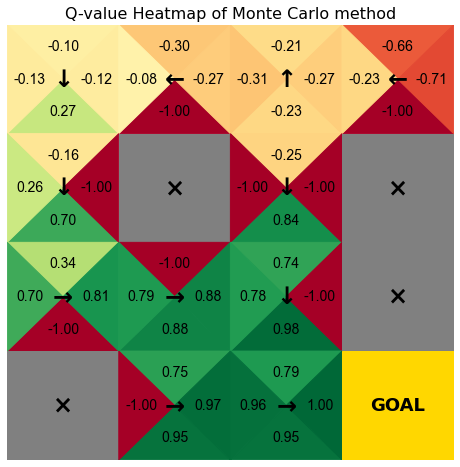

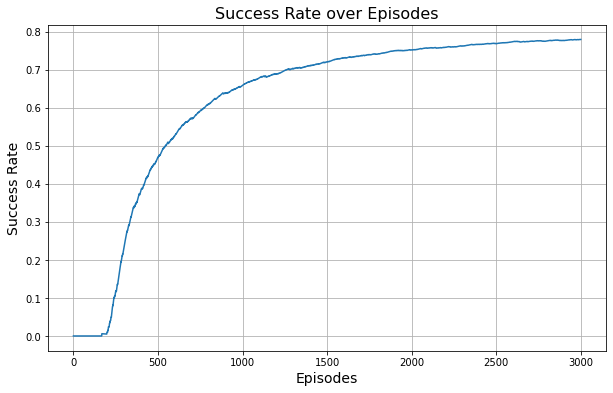

In [210]:
### Monte Carlo Method

# Environment grid representation
env = [["S", "F", "F", "F"],
       ["F", "H", "F", "H"],
       ["F", "F", "F", "H"],
       ["H", "F", "F", "G"]]

episode = 3000  # Number of episodes for training
gamma = 0.99  # Discount factor for future rewards
epsilon = 0.15  # Probability of exploration (random action)
policy_list = []  # List to store the best policy
Q = [0 for _ in range(64)]  # Q-values for each state-action pair
Q_times = [0 for _ in range(64)]  # Number of times each state-action pair has been visited
success_rate11 = []  # List to store success rates over episodes


# Reward function for each state
def reward(i, j):
    if env[i][j] == "H":
        return -1  # Negative reward for falling a hole
    elif env[i][j] == "G":
        return 1  # Positive reward for reaching the goal
    else:
        return 0  # Neutral reward for other cells


# Person class to represent the agent
class Person:
    def __init__(self):
        self.i = 0  # Initial row position
        self.j = 0  # Initial column position


# Greedy policy for action selection
def greedy(p):
    num = random.random()  # Random number to decide between exploration and exploitation
    index = p.i * 4 + p.j  # State index based on row and column
    lst = Q[index * 4:index * 4 + 4]  # Q-values for all actions at the current state
    max_value = max(lst)  # Find the maximum Q-value
    best_actions = [a + 1 for a in range(4) if lst[a] == max_value]  # Find all best actions with max Q-value
    
    if num < 1 - epsilon:
        # Exploitation: choose the best action based on Q-values
        return random.choice(best_actions)
    else:
        # Exploration: choose a random action
        return random.randint(1, 4)


# Main loop to perform the Monte Carlo Method
def loop():
    success_count = 0  # Count of successful episodes
    
    # Iterate over episodes
    for t in range(episode):
        p = Person()  # Create a new person (agent)
        s_list = [1]  # List of states encountered during the episode
        a_list = []  # List of actions taken during the episode
        
        # Run the episode until the agent reaches a terminal state (goal or hole)
        while reward(p.i, p.j) == 0:
            if t == 0:
                # In the first episode, take random actions
                a = random.randint(1, 4)
                move(p, a)  # Move the agent based on the action
            else:
                a = greedy(p)  # Take the best action based on the policy
                move(p, a)  # Move the agent based on the action
            a_list.append(a)  # Record the action
            s_list.append(p.i * 4 + p.j + 1)  # Record the state (index)
        
        # Calculate the discounted future rewards (return)
        g_list = [0 for _ in range(len(s_list))]
        for k in range(len(s_list)):
            if k == 0:
                g_list[len(s_list) - k - 1] = 0
            else:
                g_list[len(s_list) - k - 1] = reward(p.i, p.j) * gamma ** (k - 1)

        # Update Q-values for the state-action pairs visited in this episode
        for k in reversed(range(len(s_list) - 1)):
            a = a_list[k]  # Action taken at state s_k
            s = s_list[k]  # State s_k
            Q[s * 4 + a - 5] = (Q[s * 4 + a - 5] * Q_times[s * 4 + a - 5] + g_list[k]) / (Q_times[s * 4 + a - 5] + 1)
            Q_times[s * 4 + a - 5] += 1  # Increment the visit count for this state-action pair
        
        # Track success rate
        if reward(p.i, p.j) == 1:
            success_count += 1
        success_rate11.append(success_count / (t + 1))  # Append the success rate for the current episode


# Move function to update the agent's position based on the action taken
def move(p, direction):
    if direction == 1 and p.i != 0:  # Move up
        p.i += -1
    elif direction == 2 and p.i != 3:  # Move down
        p.i += 1
    elif direction == 3 and p.j != 0:  # Move left
        p.j += -1
    elif direction == 4 and p.j != 3:  # Move right
        p.j += 1


# Policy function to extract the best action from the learned Q-values
def policy():
    for i in range(16):
        lst = Q[i * 4:i * 4 + 4]  # Get Q-values for the current state
        max_index = lst.index(max(lst)) + 1  # Find the action with the highest Q-value
        policy_list.append(max_index)  # Append the best action to the policy list
    print(policy_list)  # Print the learned policy


# Function to examine the agent's performance with the learned policy
def examine():
    p = Person()  # Create a new person (agent)
    step = 0  # Step counter
    
    # Run the agent through the environment using the learned policy
    while reward(p.i, p.j) == 0 and step < 100:
        move(p, policy_list[p.i * 4 + p.j])  # Move the agent based on the policy
        step += 1
    
    # Check the result of the episode
    if reward(p.i, p.j) == 1:
        print("Success!")
    elif reward(p.i, p.j) == -1:
        print("Fail!")
    else:
        print("Endless!")


# Action arrows for display
action_arrows = {1: "↑", 2: "↓", 3: "←", 4: "→"}


# Function to get Q-values for each state-action pair
def get_q_values():
    Q_values = np.zeros((4, 4, 4))  # 4x4 grid, each cell has 4 Q-values (one for each action)
    for i in range(4):
        for j in range(4):
            state_index = i * 4 + j  # State index for the cell
            Q_values[i, j, :] = Q[state_index * 4:state_index * 4 + 4]  # Get Q-values for all actions
    return Q_values


# Function to plot the grid with policy and Q-values (Windmill style to show four directions)
def plot_grid_policy():
    Q_values = get_q_values()  # Get the Q-values matrix
    fig, ax = plt.subplots(figsize=(8, 8))  # Create the plot
    cmap = plt.cm.RdYlGn  # Color map for the heatmap

    # Draw the policy arrows and special state markings
    for i in range(4):
        for j in range(4):
            state_index = i * 4 + j

            # Mark special states (holes and goal)
            if env[i][j] == "H":  # Hole (gray color)
                rect = plt.Rectangle([j - 0.5, i - 0.5], 1, 1, color='gray')
                ax.add_patch(rect)
                ax.text(j, i, "×", ha="center", va="center", fontsize=24, fontweight="bold", color="black")

            elif env[i][j] == "G":  # Goal (gold color)
                rect = plt.Rectangle([j - 0.5, i - 0.5], 1, 1, color='gold')
                ax.add_patch(rect)
                ax.text(j, i, "GOAL", ha="center", va="center", fontsize=18, fontweight="bold", color="black")

            else:
                # Get the Q-values for the four directions
                q_up, q_down, q_left, q_right = Q_values[i, j]
                norm = plt.Normalize(vmin=-1, vmax=1)  # Normalize the Q-values for color mapping

                # Draw the directional arrows with Q-values
                triangle_up = Polygon([[j, i], [j - 0.5, i - 0.5], [j + 0.5, i - 0.5]], color=cmap(norm(q_up)))
                ax.add_patch(triangle_up)
                ax.text(j, i - 0.3, f"{q_up:.2f}", ha="center", va="center", fontsize=14, color="black", fontname='Arial')

                triangle_down = Polygon([[j, i], [j - 0.5, i + 0.5], [j + 0.5, i + 0.5]], color=cmap(norm(q_down)))
                ax.add_patch(triangle_down)
                ax.text(j, i + 0.3, f"{q_down:.2f}", ha="center", va="center", fontsize=14, color="black", fontname='Arial')

                triangle_left = Polygon([[j, i], [j - 0.5, i - 0.5], [j - 0.5, i + 0.5]], color=cmap(norm(q_left)))
                ax.add_patch(triangle_left)
                ax.text(j - 0.3, i, f"{q_left:.2f}", ha="center", va="center", fontsize=14, color="black", fontname='Arial')

                triangle_right = Polygon([[j, i], [j + 0.5, i - 0.5], [j + 0.5, i + 0.5]], color=cmap(norm(q_right)))
                ax.add_patch(triangle_right)
                ax.text(j + 0.3, i, f"{q_right:.2f}", ha="center", va="center", fontsize=14, color="black", fontname='Arial')

                # Display the best action arrow
                best_action = policy_list[state_index]
                ax.text(j, i, action_arrows[best_action], ha="center", va="center", fontsize=24, fontweight="bold", color="black")

    # Format the plot
    ax.set_xticks(np.arange(-0.5, 4, 1))
    ax.set_yticks(np.arange(-0.5, 4, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.axis("off")  # Hide axis

    plt.title("Q-value Heatmap of Monte Carlo method", fontsize=16)
    plt.gca().invert_yaxis()  # Invert the y-axis to match grid layout
    plt.show()


# Function to plot success rate over episodes
def plot_success_rate():
    """Plot the success rate over episodes"""
    plt.figure(figsize=(10, 6))  # Set figure size
    plt.plot(success_rate11)  # Plot success rate over episodes
    plt.xlabel("Episodes", fontsize=14)  # Set x-axis label
    plt.ylabel("Success Rate", fontsize=14)  # Set y-axis label
    plt.title("Success Rate over Episodes", fontsize=16)  # Set title
    plt.grid(True)  # Show grid
    plt.show()


# Main function to run the entire process
def main():
    loop()  # Train the agent
    policy()  # Print the learned policy
    examine()  # Test the learned policy
    plot_grid_policy()  # Plot the Q-value heatmap with the policy
    plot_success_rate()  # Plot success rate over episodes

if __name__ == "__main__":
    main()


### Task 1.2 SARSA Method

[4, 4, 2, 3, 2, 1, 2, 1, 4, 4, 2, 1, 1, 4, 4, 1]
Success!


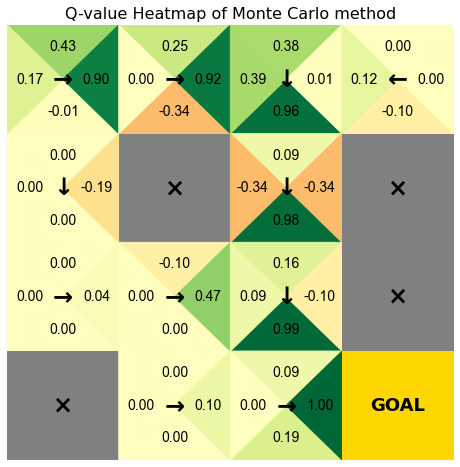

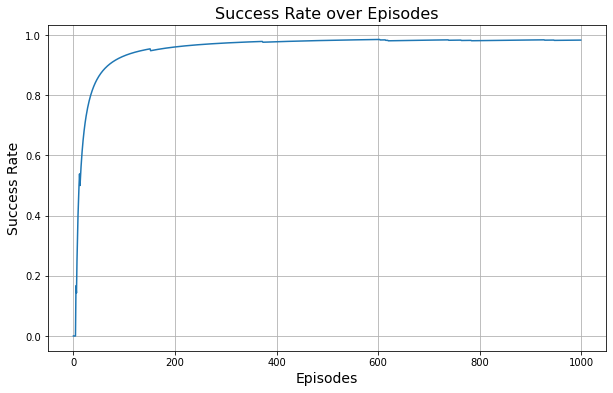

In [211]:
### SARSA Method

episode = 1000  # Total number of episodes
Q = [0 for _ in range(64)]  # Initialize Q-values (64 states with 4 possible actions)
Q_times = [0 for _ in range(64)]  # Initialize a counter for Q-value updates
gamma = 0.99  # Discount factor
epsilon = 0.01  # Exploration rate for epsilon-greedy action selection
alpha = 0.1  # Learning rate
policy_list = []  # List to store the optimal policy
success_rate12 = []  # List to store the success rate over episodes

# Main loop to perform the SARSA Method
def loop():
    global epsilon, alpha
    success_count = 0  # Track the number of successful episodes
    for t in range(episode):
        p = Person()  # Create a new person (agent)
        s_list = [1]  # List to store states
        a_list = []  # List to store actions taken

        while reward(p.i, p.j) == 0:  # Continue until reaching goal or hole
            if t == 0:  # For the first episode, take random actions
                a = random.randint(1, 4)
                move(p, a)  # Move based on action
            else:
                a = greedy(p)  # Use epsilon-greedy to select action
                move(p, a)  # Move based on the selected action

            a_list.append(a)  # Store the action
            s_list.append(p.i * 4 + p.j + 1)  # Store the state after the action

            if len(a_list) > 1:
                a0 = a_list[-2]  # Previous action
                a1 = a_list[-1]  # Current action
                s0 = s_list[-3]  # Previous state
                s1 = s_list[-2]  # Current state
                Q0 = Q[s0 * 4 + a0 - 5]  # Q-value of the previous state-action pair
                Q1 = Q[s1 * 4 + a1 - 5]  # Q-value of the current state-action pair
                R = 0  # Reward (not used in this loop)
                Q[s0 * 4 + a0 - 5] = Q0 + alpha * (R + gamma * Q1 - Q0)  # Update Q-value using SARSA rule

        # After exiting the loop, update the last state-action pair
        a0 = a_list[-1]
        s0 = s_list[-2]
        s1 = s_list[-1]
        Q0 = Q[s0 * 4 + a0 - 5]
        Q1 = 0  # Terminal state (goal or hole)
        i = (s1 - 1) // 4  # Row index of the new state
        j = (s1 - 1) % 4  # Column index of the new state
        R = reward(i, j)  # Get the reward of the new state
        Q[s0 * 4 + a0 - 5] = Q0 + alpha * (R + gamma * Q1 - Q0)  # Update the Q-value for the final state-action pair

        # Track success rate
        if reward(p.i, p.j) == 1:  # Success if the agent reaches the goal
            success_count += 1
        success_rate12.append(success_count / (t + 1))  # Update success rate

# Function to plot success rate over episodes
def plot_success_rate():
    """Plot the success rate over episodes"""
    plt.figure(figsize=(10, 6))  # Set figure size
    plt.plot(success_rate12)  # Plot success rate over episodes
    plt.xlabel("Episodes", fontsize=14)  # Set x-axis label
    plt.ylabel("Success Rate", fontsize=14)  # Set y-axis label
    plt.title("Success Rate over Episodes", fontsize=16)  # Set title
    plt.grid(True)  # Show grid
    plt.show()

if __name__ == "__main__":
    main()


### Task 1.3 Q-learning Method

[4, 4, 2, 3, 1, 1, 2, 1, 1, 4, 2, 1, 1, 4, 4, 1]
Success!


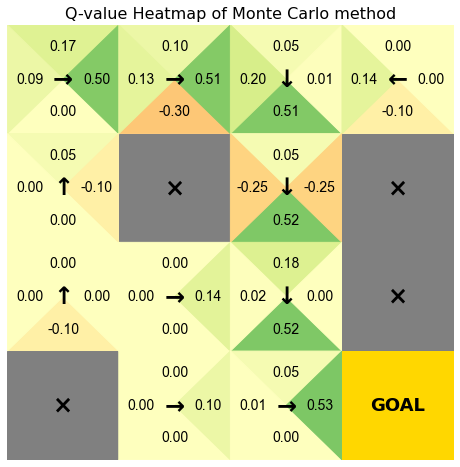

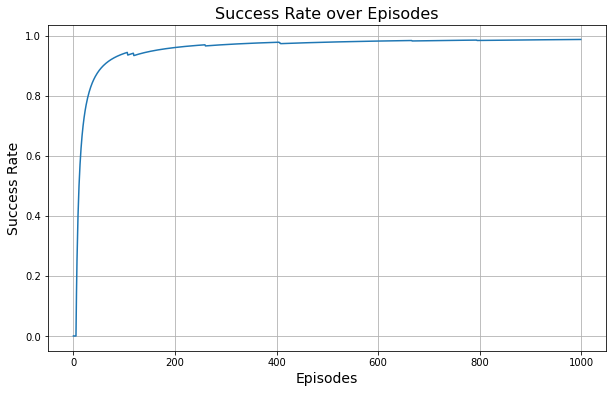

In [212]:
### Q-learning Method

episode = 1000  # Total number of episodes
Q = [0 for _ in range(64)]  # Initialize Q-values (64 states with 4 possible actions)
Q_times = [0 for _ in range(64)]  # Initialize a counter for Q-value updates
gamma = 0.99  # Discount factor
epsilon = 0.01  # Exploration rate for epsilon-greedy action selection
alpha = 0.1  # Learning rate
policy_list = []  # List to store the optimal policy
success_rate13 = []  # List to store the success rate over episodes

# Main loop to perform the Q-learning Method
def loop():
    """Run the Q-learning algorithm."""
    global epsilon, alpha
    success_count = 0  # Track the number of successful episodes
    for t in range(episode):
        p = Person()  # Create a new person (agent)
        s_list = [1]  # List to store states
        a_list = []  # List to store actions taken
        
        while reward(p.i, p.j) == 0:  # Continue until reaching goal or hole
            if t == 0:  # For the first episode, take random actions
                a = random.randint(1, 4)
                move(p, a)  # Move based on action
            else:
                a = greedy(p)  # Use epsilon-greedy to select action
                move(p, a)  # Move based on the selected action

            a_list.append(a)  # Store the action
            s_list.append(p.i * 4 + p.j + 1)  # Store the state after the action

            # Q-learning update step
            a0 = a_list[-1]  # Current action
            s0 = s_list[-2]  # Previous state
            s1 = s_list[-1]  # Current state
            Q0 = Q[s0 * 4 + a0 - 5]  # Q-value of the previous state-action pair
            Q1 = max(Q[s1 * 4 - 4:s1 * 4])  # Maximum Q-value for the current state
            R = 0  # Reward (not used in this loop)
            Q[s0 * 4 + a0 - 5] = Q0 + alpha * (R + gamma * Q1 - Q0)  # Update Q-value using Q-learning rule

        # After exiting the loop, update the last state-action pair
        a0 = a_list[-1]  # Last action
        s0 = s_list[-2]  # Previous state
        s1 = s_list[-1]  # Current state
        Q0 = Q[s0 * 4 + a0 - 5]  # Q-value of the previous state-action pair
        Q1 = max(Q[s1 * 4 - 4:s1 * 4])  # Maximum Q-value for the current state
        R = reward(p.i, p.j)  # Get the reward for the current state
        Q[s0 * 4 + a0 - 5] = Q0 + alpha * (R + gamma * Q1 - Q0)  # Update Q-value for the final state-action pair
        
        # Track success rate
        if reward(p.i, p.j) == 1:  # Success if the agent reaches the goal
            success_count += 1
        success_rate13.append(success_count / (t + 1))  # Update success rate

# Function to plot the success rate over episodes
def plot_success_rate():
    """Plot the success rate over episodes."""
    plt.figure(figsize=(10, 6))  # Set figure size
    plt.plot(success_rate13)  # Plot the success rate curve
    plt.xlabel("Episodes", fontsize=14)  # X-axis label
    plt.ylabel("Success Rate", fontsize=14)  # Y-axis label
    plt.title("Success Rate over Episodes", fontsize=16)  # Title
    plt.grid(True)  # Add grid lines for better visibility of trends
    plt.show()

if __name__ == "__main__":
    main()

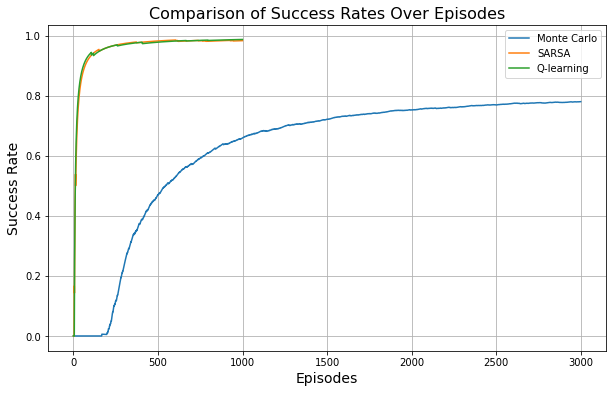

In [213]:
# Get the maximum length of success rates for different algorithms
max_len = max(len(success_rate11), len(success_rate12), len(success_rate13))

# Create x-axis values for each algorithm based on their lengths
episodes11 = np.arange(len(success_rate11))  # X-axis values for Monte Carlo
episodes12 = np.arange(len(success_rate12))  # X-axis values for SARSA
episodes13 = np.arange(len(success_rate13))  # X-axis values for Q-learning

# Plotting the success rates of the three algorithms over episodes
plt.figure(figsize=(10, 6))  # Set the figure size (width, height in inches)
plt.plot(episodes11, success_rate11, label="Monte Carlo")  # Plot Monte Carlo success rate
plt.plot(episodes12, success_rate12, label="SARSA")  # Plot SARSA success rate
plt.plot(episodes13, success_rate13, label="Q-learning")  # Plot Q-learning success rate

# Add title and axis labels to the plot
plt.xlabel("Episodes", fontsize=14)  # X-axis label with font size 14
plt.ylabel("Success Rate", fontsize=14)  # Y-axis label with font size 14
plt.title("Comparison of Success Rates Over Episodes", fontsize=16)  # Title with font size 16
plt.legend()  # Display the legend for the three algorithms
plt.grid(True)  # Add grid lines to the plot for better visualization

# Display the plot
plt.show()

### Task 2.1 Monte Carlo Method

[[4 2 1 1 1 1 1 1 1 1]
 [1 2 3 1 1 1 1 1 1 1]
 [2 3 1 1 1 1 1 1 1 1]
 [2 1 1 1 3 1 1 2 1 1]
 [4 2 3 3 2 3 2 2 1 2]
 [2 3 1 1 2 1 1 2 1 2]
 [4 2 3 1 3 1 1 2 2 2]
 [1 2 1 1 4 2 3 2 4 2]
 [2 2 2 1 2 2 4 2 2 2]
 [2 4 4 4 4 4 4 4 4 1]]
Success!


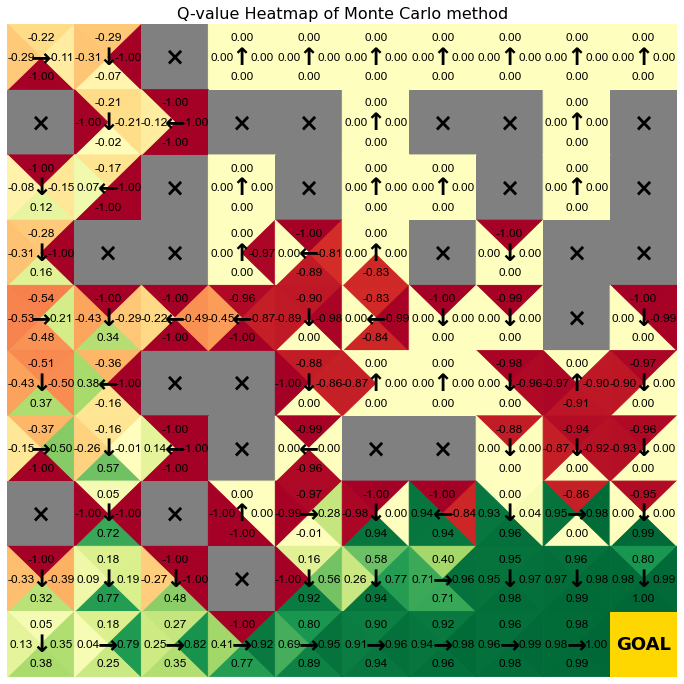

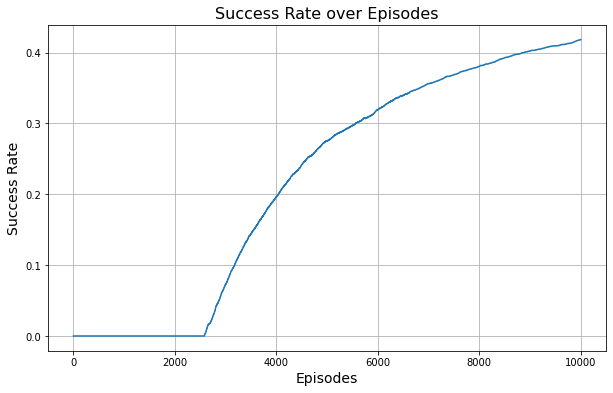

In [214]:
### Monte Carlo Method

# Environment setup: A 10x10 grid with different types of cells
env = [
    ["S", "F", "H", "F", "F", "F", "F", "F", "F", "F"],
    ["H", "F", "F", "H", "H", "F", "H", "H", "F", "H"],
    ["F", "F", "H", "F", "H", "F", "F", "H", "F", "H"],
    ["F", "H", "H", "F", "F", "F", "H", "F", "H", "H"],
    ["F", "F", "F", "F", "F", "F", "F", "F", "H", "F"],
    ["F", "F", "H", "H", "F", "F", "F", "F", "F", "F"],
    ["F", "F", "F", "H", "F", "H", "H", "F", "F", "F"],
    ["H", "F", "H", "F", "F", "F", "F", "F", "F", "F"],
    ["F", "F", "F", "H", "F", "F", "F", "F", "F", "F"],
    ["F", "F", "F", "F", "F", "F", "F", "F", "F", "G"]
]

# Hyperparameters
episode = 10000
Q = [0 for _ in range(400)]  # Q-values for each state-action pair
Q_times = [0 for _ in range(400)]  # Number of times each state-action pair has been visited
gamma = 0.99  # Discount factor
epsilon = 0.15  # Exploration factor
policy_list = []  # List to store the best actions for each state
success_rate21 = []  # List to store the success rate during training

# Reward function that returns rewards based on the environment cell type
def reward(i, j):
    if env[i][j] == "H":
        return -1  # Hole cell (penalty)
    elif env[i][j] == "G":
        return 1  # Goal cell (reward)
    else:
        return 0  # Free cell (no reward)

# Class to represent the agent (person) on the grid
class Person:
    def __init__(self):
        self.i = 0  # Row position
        self.j = 0  # Column position
    
# Greedy policy for action selection
def greedy(p):
    num = random.random()  # Random number to decide between exploration and exploitation
    index = p.i * 10 + p.j  # State index based on row and column
    lst = Q[index * 4:index * 4 + 4]  # Q-values for all actions at the current state
    max_value = max(lst)  # Find the maximum Q-value
    best_actions = [a + 1 for a in range(4) if lst[a] == max_value]  # Find all best actions with max Q-value
    
    if num < 1 - epsilon:
        # Exploitation: choose the best action based on Q-values
        return random.choice(best_actions)
    else:
        # Exploration: choose a random action
        return random.randint(1, 4)

# Training loop for Monte Carlo method
def loop():
    global epsilon
    success_count = 0  # Counter for successful episodes
    
    for t in range(episode):
        p = Person()  # Reset agent position
        s_list = [1]  # List of states visited in the episode
        a_list = []  # List of actions taken in the episode
        
        # Episode loop until the agent reaches a terminal state (Goal or Hole)
        while reward(p.i, p.j) == 0:
            if t == 0:
                a = random.randint(1, 4)  # Random initial action
                move(p, a)
            else:
                a = greedy(p)  # Action chosen by greedy policy
                move(p, a)
            a_list.append(a)
            s_list.append(p.i * 10 + p.j + 1)  # Record the state (row * 10 + column + 1)
        
        # Calculate the return (discounted reward) for each state-action pair
        g_list = [0 for _ in range(len(s_list))]
        for k in range(len(s_list)):
            if k == 0:
                g_list[len(s_list) - k - 1] = 0
            else:
                g_list[len(s_list) - k - 1] = reward(p.i, p.j) * gamma ** (k - 1)
        
        # Update Q-values using the Monte Carlo method
        check = []
        for k in reversed(range(len(s_list) - 1)):
            a = a_list[k]
            s = s_list[k]
            if s * 4 + a - 5 not in check:
                Q[s * 4 + a - 5] = (Q[s * 4 + a - 5] * Q_times[s * 4 + a - 5] + g_list[k]) / (
                    Q_times[s * 4 + a - 5] + 1)
                Q_times[s * 4 + a - 5] += 1
                check.append(s * 4 + a - 5)
        
        # Track the success rate
        if reward(p.i, p.j) == 1:
            success_count += 1
        success_rate21.append(success_count / (t + 1))

# Move function to update the agent's position based on the chosen action
def move(p, direction):
    if direction == 1 and p.i != 0:
        p.i += -1  # Move up
    elif direction == 2 and p.i != 9:
        p.i += 1  # Move down
    elif direction == 3 and p.j != 0:
        p.j += -1  # Move left
    elif direction == 4 and p.j != 9:
        p.j += 1  # Move right

# Policy function to extract the best actions from Q-values
def policy():
    for i in range(100):
        lst = Q[i * 4:i * 4 + 4]
        max_index = lst.index(max(lst)) + 1  # Best action based on Q-values
        policy_list.append(max_index)  # Store the best action for each state
    
    # Print policy in a 10x10 grid format
    policy_matrix = np.array(policy_list).reshape(10, 10)
    print(policy_matrix)

# Function to test the learned policy by simulating a single episode
def examine():
    p = Person()
    step = 0
    while reward(p.i, p.j) == 0 and step < 100:
        move(p, policy_list[p.i * 10 + p.j])  # Move according to the policy
        step += 1
    if reward(p.i, p.j) == 1:
        print("Success!")
    elif reward(p.i, p.j) == -1:
        print("Fail!")
    else:
        print("Endless!")

# Mapping actions to arrows for visualization
action_arrows = {1: "↑", 2: "↓", 3: "←", 4: "→"}

# Function to get Q-values for each state and each direction
def get_q_values():
    Q_values = np.zeros((10, 10, 4))  # 10x10 grid, each state has 4 Q-values
    for i in range(10):
        for j in range(10):
            state_index = i * 10 + j
            Q_values[i, j, :] = Q[state_index * 4:state_index * 4 + 4]  # Extract Q-values for the current state
    return Q_values

# Function to plot the grid with policy and Q-value heatmap
def plot_grid_policy():
    Q_values = get_q_values()  # Get the Q-values for the grid
    fig, ax = plt.subplots(figsize=(12, 12))  # Create a plot with a specific size
    cmap = plt.cm.RdYlGn  # Color map for the heatmap

    # Draw arrows and heatmap for each cell
    for i in range(10):
        for j in range(10):
            state_index = i * 10 + j

            # Special cases for Hole and Goal cells
            if env[i][j] == "H":  # Hole cell (gray)
                rect = plt.Rectangle([j - 0.5, i - 0.5], 1, 1, color='gray')
                ax.add_patch(rect)
                ax.text(j, i, "×", ha="center", va="center", fontsize=24, fontweight="bold", color="black")
            elif env[i][j] == "G":  # Goal cell (gold)
                rect = plt.Rectangle([j - 0.5, i - 0.5], 1, 1, color='gold')
                ax.add_patch(rect)
                ax.text(j, i, "GOAL", ha="center", va="center", fontsize=18, fontweight="bold", color="black")
            else:
                # Plot Q-values for the four possible directions
                q_up, q_down, q_left, q_right = Q_values[i, j]
                norm = plt.Normalize(vmin=-1, vmax=1)

                # Draw the four arrows representing the Q-values
                triangle_up = Polygon([[j, i], [j - 0.5, i - 0.5], [j + 0.5, i - 0.5]], 
                                      color=cmap(norm(q_up)))
                ax.add_patch(triangle_up)
                ax.text(j, i - 0.3, f"{q_up:.2f}", ha="center", va="center", fontsize=12, color="black", fontname='Arial')

                triangle_down = Polygon([[j, i], [j - 0.5, i + 0.5], [j + 0.5, i + 0.5]], 
                                        color=cmap(norm(q_down)))
                ax.add_patch(triangle_down)
                ax.text(j, i + 0.3, f"{q_down:.2f}", ha="center", va="center", fontsize=12, color="black", fontname='Arial')

                triangle_left = Polygon([[j, i], [j - 0.5, i - 0.5], [j - 0.5, i + 0.5]], 
                                        color=cmap(norm(q_left)))
                ax.add_patch(triangle_left)
                ax.text(j - 0.3, i, f"{q_left:.2f}", ha="center", va="center", fontsize=12, color="black", fontname='Arial')

                triangle_right = Polygon([[j, i], [j + 0.5, i - 0.5], [j + 0.5, i + 0.5]], 
                                         color=cmap(norm(q_right)))
                ax.add_patch(triangle_right)
                ax.text(j + 0.3, i, f"{q_right:.2f}", ha="center", va="center", fontsize=12, color="black", fontname='Arial')

                # Display the optimal action as an arrow
                best_action = policy_list[state_index]
                ax.text(j, i, action_arrows[best_action], ha="center", va="center", fontsize=24, fontweight="bold", color="black")

    # Format the plot
    ax.set_xticks(np.arange(-0.5, 10, 1))
    ax.set_yticks(np.arange(-0.5, 10, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.axis("off")  # Hide the axis

    plt.title("Q-value Heatmap of Monte Carlo method", fontsize=16)
    plt.gca().invert_yaxis()  # Invert y-axis to match grid layout
    plt.show()

# Function to plot the success rate over episodes
def plot_success_rate():
    plt.figure(figsize=(10, 6))
    plt.plot(success_rate21)
    plt.xlabel("Episodes", fontsize=14)
    plt.ylabel("Success Rate", fontsize=14)
    plt.title("Success Rate over Episodes", fontsize=16)
    plt.grid(True)
    plt.show()

# Main function to run the entire Monte Carlo method
def main():
    loop()  # Run the Monte Carlo training loop
    policy()  # Generate the optimal policy
    examine()  # Test the learned policy
    plot_grid_policy()  # Plot the grid policy and Q-value heatmap
    plot_success_rate()  # Plot the success rate over episodes

# Run the main function
if __name__ == "__main__":
    main()


### Task 2.2 SARSA Method

[[4 2 1 1 1 1 1 1 1 1]
 [1 2 3 1 1 1 1 1 1 1]
 [2 3 1 2 1 1 3 1 1 1]
 [2 1 1 1 2 1 1 2 1 1]
 [2 3 4 4 2 3 2 1 1 1]
 [2 2 1 1 2 1 1 1 2 1]
 [4 2 3 1 2 1 1 2 2 1]
 [1 2 1 4 2 2 2 2 2 1]
 [2 2 2 1 4 4 2 4 4 2]
 [4 4 4 4 4 4 4 4 4 1]]
Success!


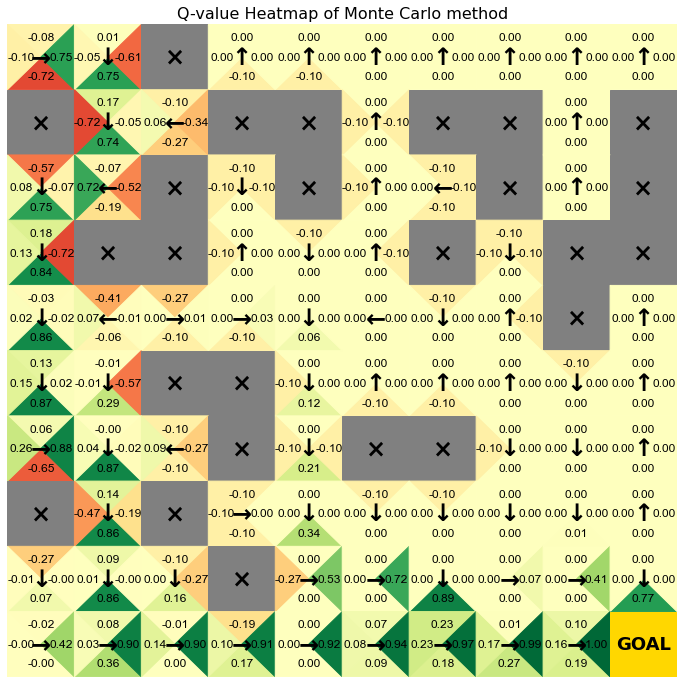

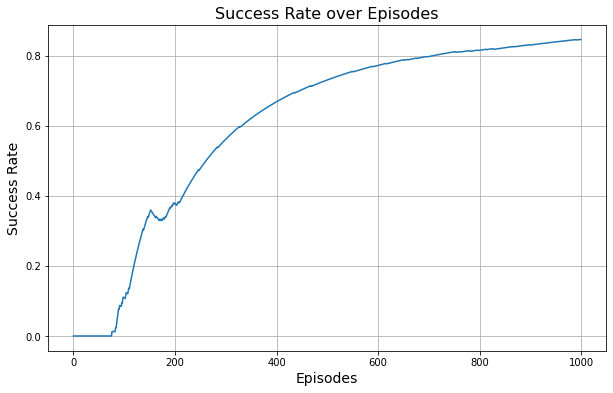

In [215]:
# SARSA Method

# Initialize the parameters
episode = 1000  # Number of episodes
Q = [0 for _ in range(400)]  # Q-table initialization (4 actions per state)
Q_times = [0 for _ in range(400)]  # To count how many times each state-action pair is updated
gamma = 0.99  # Discount factor
epsilon = 0.01  # Exploration probability
alpha = 0.1  # Learning rate
policy_list = []  # List to store the final policy
success_rate22 = []  # List to record the success rate during training

# Main loop to run the SARSA algorithm
def loop():
    global epsilon
    success_count = 0  # Initialize the success count to track the number of successful episodes
    
    for t in range(episode):  # Iterate over the number of episodes
        p = Person()  # Create a new Person object (agent)
        s_list = [1]  # List to store state indices
        a_list = []  # List to store action indices
        
        # Run the agent until it reaches the goal or an obstacle
        while reward(p.i, p.j) == 0:
            if t == 0:  # For the first episode, start with random actions
                a = random.randint(1, 4)
                move(p, a)
            else:  # For other episodes, use the SARSA method
                a = greedy(p)  # Choose action based on the greedy policy
                move(p, a)
            
            a_list.append(a)  # Add the action to the action list
            s_list.append(p.i * 10 + p.j + 1)  # Store the state index
            
            if len(a_list) > 1:  # If there are more than one action taken
                # Update the Q-value for the previous state-action pair (SARSA update)
                a0 = a_list[-2]  # The action taken in the previous step
                a1 = a_list[-1]  # The action taken in the current step
                s0 = s_list[-3]  # The previous state
                s1 = s_list[-2]  # The current state
                Q0 = Q[s0 * 4 + a0 - 5]  # The previous Q-value
                Q1 = Q[s1 * 4 + a1 - 5]  # The Q-value of the current state-action pair
                R = 0  # Get the reward for the new state
                Q[s0 * 4 + a0 - 5] = Q0 + alpha * (R + gamma * Q1 - Q0)  # SARSA update formula
        
        # After the episode ends, update the Q-value for the last state-action pair
        a0 = a_list[-1]  # The last action taken
        s0 = s_list[-2]  # The state before the last move
        s1 = s_list[-1]  # The state after the last move
        Q0 = Q[s0 * 4 + a0 - 5]  # The previous Q-value
        Q1 = 0  # No further action after reaching the goal, so Q1 is 0
        i = (s1 - 1) // 10  # Extract the row index from the state index
        j = (s1 - 1) % 10   # Extract the column index from the state index
        R = reward(i, j)    # Get the reward for the new state
        Q[s0 * 4 + a0 - 5] = Q0 + alpha * (R + gamma * Q1 - Q0)  # Final Q-value update for the last action

        # Record the success rate after each episode
        if reward(p.i, p.j) == 1:  # If the agent reaches the goal
            success_count += 1
        success_rate22.append(success_count / (t + 1))  # Calculate success rate for each episode

# Function to plot the success rate over episodes
def plot_success_rate():
    """Plot the success rate as it changes over episodes"""
    plt.figure(figsize=(10, 6))  # Set the size of the plot
    plt.plot(success_rate22)  # Plot the success rate curve
    plt.xlabel("Episodes", fontsize=14)  # Label for the x-axis
    plt.ylabel("Success Rate", fontsize=14)  # Label for the y-axis
    plt.title("Success Rate over Episodes", fontsize=16)  # Title for the plot
    plt.grid(True)  # Add a grid to the plot for better visibility of trends
    plt.show()  # Display the plot

# Main entry point to execute the SARSA method and plot results
if __name__ == "__main__":
    main()  # Run the main function that trains and evaluates the SARSA algorithm


### Task 2.3 Q-learning Method

[[4 2 1 1 1 1 1 1 1 1]
 [1 2 3 1 1 1 1 1 1 1]
 [2 3 1 2 1 1 3 1 1 1]
 [2 1 1 1 2 1 1 2 1 1]
 [2 2 3 1 1 1 2 1 1 1]
 [2 3 1 1 1 1 1 1 2 1]
 [4 2 3 1 1 1 1 1 1 1]
 [1 2 1 1 1 2 1 2 3 1]
 [4 2 2 1 4 4 4 2 3 2]
 [4 4 4 4 4 4 4 4 4 1]]
Success!


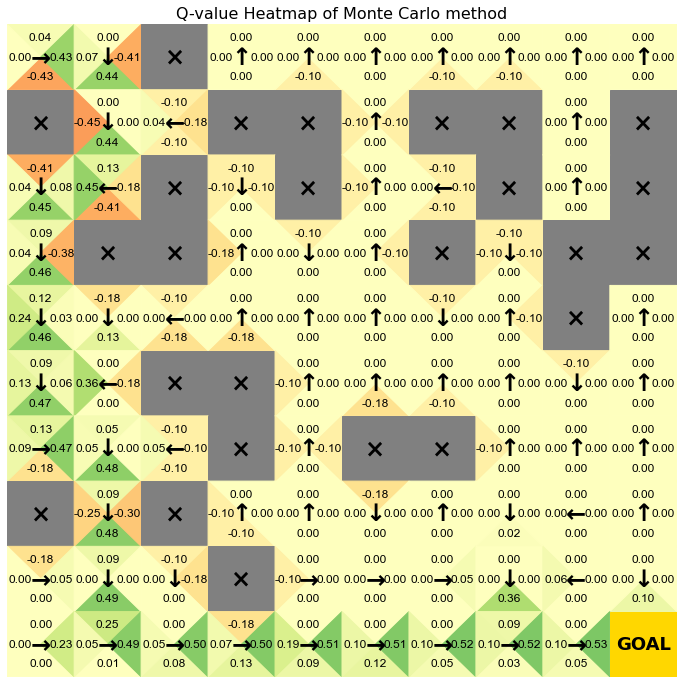

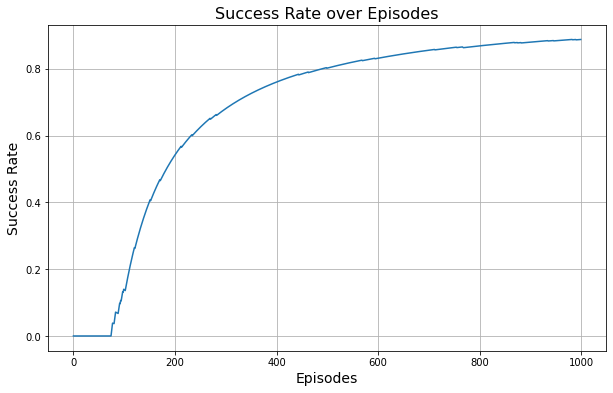

In [216]:
# Q-learning Method Implementation

# Initialize the parameters
episode = 1000  # Number of episodes
Q = [0 for _ in range(400)]  # Q-table initialization (4 actions per state)
Q_times = [0 for _ in range(400)]  # To count how many times each state-action pair is updated
gamma = 0.99  # Discount factor
epsilon = 0.01  # Exploration probability
alpha = 0.1  # Learning rate
policy_list = []  # List to store the final policy
success_rate23 = []  # List to record the success rate during training

# Main loop to run the Q-learning algorithm
def loop():
    global epsilon
    success_count = 0  # Initialize the success count to track the number of successful episodes
    
    for t in range(episode):  # Iterate over the number of episodes
        p = Person()  # Create a new Person object (agent)
        s_list = [1]  # List to store state indices
        a_list = []  # List to store action indices
        
        # Run the agent until it reaches the goal or an obstacle
        while reward(p.i, p.j) == 0:
            if t == 0:  # For the first episode, start with random actions
                a = random.randint(1, 4)
                move(p, a)
            else:  # For other episodes, use the Q-learning method
                a = greedy(p)  # Choose action based on the greedy policy
                move(p, a)
            
            a_list.append(a)  # Add the action to the action list
            s_list.append(p.i * 10 + p.j + 1)  # Store the state index
            
            # Q-learning update rule for each step
            a0 = a_list[-1]  # The action taken in the current step
            s0 = s_list[-2]  # The previous state
            s1 = s_list[-1]  # The current state
            Q0 = Q[s0 * 4 + a0 - 5]  # The previous Q-value for state-action pair
            Q1 = max(Q[s1 * 4 - 4 : s1 * 4])  # Max Q-value for the next state (greedy action)
            R = 0  # Reward is not calculated yet
            Q[s0 * 4 + a0 - 5] = Q0 + alpha * (R + gamma * Q1 - Q0)  # Update the Q-value using the Q-learning formula
        
        # After the episode ends, update the Q-value for the last state-action pair
        a0 = a_list[-1]  # The last action taken
        s0 = s_list[-2]  # The state before the last move
        s1 = s_list[-1]  # The state after the last move
        Q0 = Q[s0 * 4 + a0 - 5]  # The previous Q-value
        Q1 = max(Q[s1 * 4 - 4 : s1 * 4])  # Max Q-value for the next state (greedy action)
        R = reward(p.i, p.j)  # Get the reward for the new state
        Q[s0 * 4 + a0 - 5] = Q0 + alpha * (R + gamma * Q1 - Q0)  # Final Q-value update for the last action

        # Record the success rate after each episode
        if reward(p.i, p.j) == 1:  # If the agent reaches the goal
            success_count += 1
        success_rate23.append(success_count / (t + 1))  # Calculate success rate for each episode

# Function to plot the success rate over episodes
def plot_success_rate():
    """Plot the success rate as it changes over episodes"""
    plt.figure(figsize=(10, 6))  # Set the size of the plot
    plt.plot(success_rate23)  # Plot the success rate curve
    plt.xlabel("Episodes", fontsize=14)  # Label for the x-axis
    plt.ylabel("Success Rate", fontsize=14)  # Label for the y-axis
    plt.title("Success Rate over Episodes", fontsize=16)  # Title for the plot
    plt.grid(True)  # Add a grid to the plot for better visibility of trends
    plt.show()  # Display the plot

# Main entry point to execute the Q-learning method and plot results
if __name__ == "__main__":
    main()  # Run the main function that trains and evaluates the Q-learning algorithm

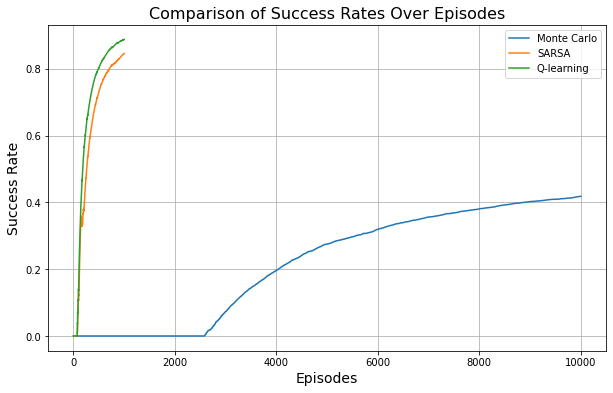

In [217]:
# Getting the maximum length of the success rate lists
max_len = max(len(success_rate21), len(success_rate22), len(success_rate23))

# Create x-axis for plotting (episode numbers for each method)
episodes21 = np.arange(len(success_rate21))  # For Monte Carlo method
episodes22 = np.arange(len(success_rate22))  # For SARSA method
episodes23 = np.arange(len(success_rate23))  # For Q-learning method

# Plotting the success rates of the three methods
plt.figure(figsize=(10, 6))  # Set the size of the figure
plt.plot(episodes21, success_rate21, label="Monte Carlo")  # Plot success rate for Monte Carlo method
plt.plot(episodes22, success_rate22, label="SARSA")  # Plot success rate for SARSA method
plt.plot(episodes23, success_rate23, label="Q-learning")  # Plot success rate for Q-learning method

# Adding title and labels to the plot
plt.xlabel("Episodes", fontsize=14)  # Label for x-axis (number of episodes)
plt.ylabel("Success Rate", fontsize=14)  # Label for y-axis (success rate)
plt.title("Comparison of Success Rates Over Episodes", fontsize=16)  # Title of the plot
plt.legend()  # Add a legend to distinguish between the different methods
plt.grid(True)  # Add a grid to the plot for better visualization of trends

# Display the plot
plt.show()  # Show the plot to the user